# Recurrent models

In this lab, we will start working with the time series of ATM failures, in order to classify them. There are many other applications possible, such as clustering, regression, or even anomaly detection using autoencoders.

As always, let's first import the packages we will use and the data.

In [ ]:
import numpy as np
import PIL
import os

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder

# For validation
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
%matplotlib inline

# Import Libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset


In [ ]:
!gdown https://drive.google.com/uc?id=1rQfs6djY8MjeMPqHxl0cHbqTCwLB3giD

In [ ]:
!unzip ATM.zip
!rm ATM.zip

Now we read the data. It comes from [this Github](https://github.com/victormvy/sigma-convkernels/blob/main/main.py) and [its related paper](https://arxiv.org/ftp/arxiv/papers/2305/2305.10059.pdf) that uses the logs from ATM to detect failures. The failures can be either because of foreign body, generic failure, jam, preventive maintenance, replacement of any part or bad usage. There are 38 measurements the ATM keeps track of over a day, divided into series of 144 points. So, our input is a matrix of size (38, 144) for every point, predicting if the machine will be functional one week into the future.

The following image, from the paper, describes the data.



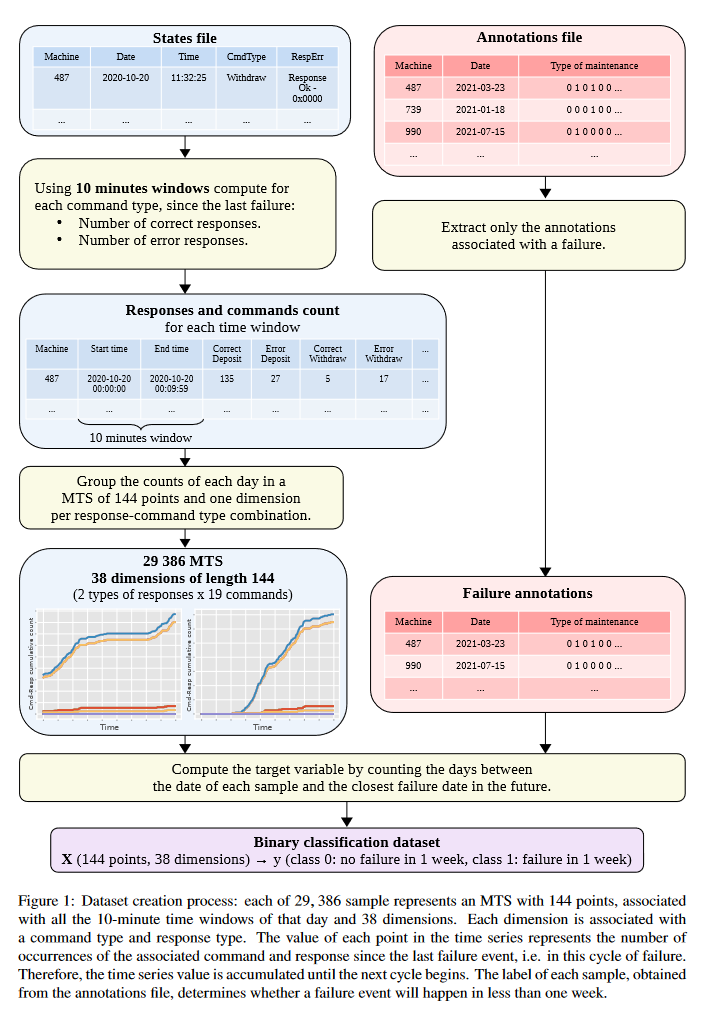

In [2]:
# Read the data
data = np.load('sigma_pdm.npy', allow_pickle=True)

X = data[:, :-4, :]
y = data[:, -4:, -1]

del data

# Move to pandas
y_df = pd.DataFrame(y, columns = ['ID', 'Day', 'Type', 'Status'])

In [3]:
# Create Pandas DataFrame for X
x_df = pd.DataFrame.from_records(X)
x_df

# Add the target
x_df['target'] = y_df['Status'].values

# Split the data
seed = 20240202
x_df['if_test'] = np.random.RandomState(seed=seed).binomial(1, 0.3, size=x_df.shape[0])
x_df.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,target,if_test
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0
1,"[64, 65, 66, 66, 66, 67, 67, 67, 68, 69, 72, 7...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[64, 65, 66, 66, 66, 67, 67, 67, 68, 69, 72, 7...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[64, 65, 66, 66, 66, 66, 67, 67, 68, 69, 72, 7...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[69, 70, 71, 71, 71, 71, 72, 72, 73, 74, 77, 7...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[69, 70, 71, 71, 71, 71, 72, 72, 73, 74, 77, 7...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0
2,"[130, 130, 130, 130, 130, 130, 130, 130, 130, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[130, 130, 130, 130, 130, 130, 130, 130, 130, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[130, 130, 130, 130, 130, 130, 130, 130, 130, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[141, 141, 141, 141, 141, 141, 141, 141, 141, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[141, 141, 141, 141, 141, 141, 141, 141, 141, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0
3,"[161, 162, 163, 163, 164, 166, 166, 167, 168, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[161, 162, 163, 163, 164, 166, 166, 167, 168, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[161, 162, 163, 163, 164, 166, 166, 167, 167, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[175, 176, 178, 178, 179, 182, 183, 184, 184, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[175, 176, 178, 178, 179, 182, 183, 184, 184, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0
4,"[193, 193, 193, 193, 193, 193, 193, 193, 193, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[193, 193, 193, 193, 193, 193, 193, 193, 193,

In [4]:
# Delete the original data
del X, y

Now we can plot one of the series for one of the cases.

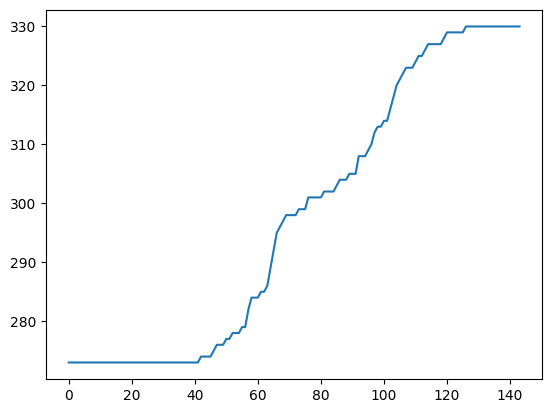

In [5]:
# For case 3, plot series 9.
plt.plot(x_df[2][8])
plt.show()

Now we are ready to start training models. Let's define torch's device so it runs the most efficient way possible.

In [6]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")

print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

# Making the code device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"The default device is set to {device}")

Is CUDA supported by this system? True
CUDA version: 12.1
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA TITAN RTX
The default device is set to cuda


## Long-Short Term Memory (LSTM) Networks



First, we will train an LSTM. The LSTM is a fairly complex model, so VRAM will be a signficant constraint. Let's first set up the train and test dataset. We will normalize the data and One Hot Encode the labels using sklearn's [OneHotEncode](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) function. We will also set the class weights as we have done before.

In [7]:
# Create train and test datasets.
x_column = 8
x_train = np.array([val.ravel() for val in x_df.loc[x_df['if_test']==0, x_column]])
x_test = np.array([val.ravel() for val in x_df.loc[x_df['if_test']==1, x_column]])

# Normalize train and test
max_value = x_train.max()
min_value = x_train.min()

x_train = (x_train - min_value) / (max_value - min_value)
x_test = (x_test - min_value) / (max_value - min_value)

# Encode test set
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
y_train = enc.fit_transform(x_df.loc[x_df['if_test']==0, 'target'].values.reshape(-1, 1))
y_test = enc.transform(x_df.loc[x_df['if_test']==1, 'target'].values.reshape(-1, 1))

# Class weights
y_integers = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_integers),
                                                  y=y_integers)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 0.5591639175815262, 1: 4.72554844606947}


Now we will create the LSTM. First, let's try to be naïve and see what happens if we simply try to train our LSTM using 32 cells and just passing the sequence. As we saw in the lectures, Google's LeNet showed that stacking parallel layers of convolution (so, not sequential models) seemed like a good idea. Would this idea work with LSTM?

Let's find out. For this, we will create a pytorch model and it's corresponding forward pass. We will use an LSTM to create an output embedding of the time series, and then pass that to a dense layer with droput that will classify the sequence. Finally, we will determine if the sequence is a suggesting a failure or not with a sigmoid output layer. 


In [19]:
# Define the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, classifier_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Classifier network
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, classifier_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(classifier_dim, output_dim),
            nn.Softmax(dim=1)
       )
    
    # Forward method
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        out, (hn, cn) = self.lstm(x, (h0[:, 0:1, :], c0[:, 0:1, :]))
        out = self.classifier(out[:, -1, :])
        return out


Let's initatiate the model and see the diagram.

In [ ]:
!pip install torchview

In [21]:
# Initialize the model
sequence_length = len(x_df.iloc[1, 1])
atm_lstm_model = LSTMClassifier(sequence_length, 128, 1, 256, 1).to(device)
print(atm_lstm_model)

LSTMClassifier(
  (lstm): LSTM(144, 128, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=1, bias=True)
    (4): Softmax(dim=1)
  )
)


In [10]:
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')


'svg'

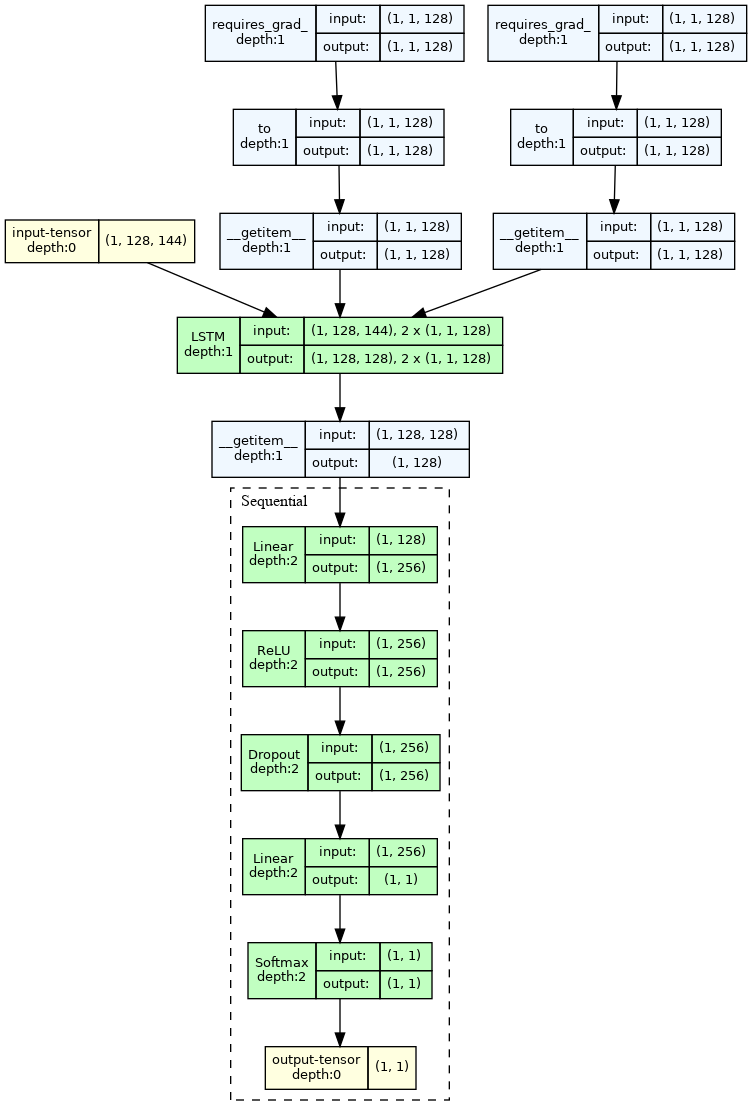

In [25]:
# Draw the model
model_graph = draw_graph(atm_lstm_model, input_size=(1, 128, 144), 
                         device=device,     
                         expand_nested=True)
model_graph.visual_graph


Now we are ready to train. Recurrent models are very tricky in terms of their training, and the gradients usually present a very static behaviour. It is a good idea to clip the gradients, that is, to lower the value of the gradient so it does not explode. All Keras optimizers come with a `clipnorm` and `clipvalue` parameter, which allows to set a maximum relative value against the mean for the gradient, or a maximum absolute value for it, respectively.

I would generally advice to use `clipnorm` at a value of around 1 to 2 if you are seeing erratic training behaviour.

Also, Adam seems like a good training optimizer for these models, as long as clipnorm is used, like so:

In [ ]:
lstm_sleep_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5,
                                                         clipnorm=0.1 # Set a maximum value for the gradient
                                                         ),
                         loss="categorical_crossentropy",
                         metrics=["accuracy"])

Let's train the model and plot the training history.

In [ ]:
# Now we can finally train!
history = lstm_sleep_model.fit(x=x_train,
                               y=y_train,
                               epochs=10,
                               batch_size=64,
                               validation_split=0.2,
                               callbacks=my_callbacks,
                               class_weight=class_weights_dict
                               )

In [ ]:
loss = lstm_sleep_model.history.history['loss']
val_loss = lstm_sleep_model.history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

As we can see, the model performs very poorly, never achieving good accuracy. Why is this? Well, our sequences are 6,000 elements long and are not regularized in any way. This causes the model to not be able to perform properly.

A good rule of thumb is that the sequences should never be longer than 1,000 inputs, and many suggests to keep it at around 128 - 256. So we should do something about that. We have several options:

1. Use a rolling mean or other downsampling with a filter to aggregate the signal.
2. Use [1D convolutional layers](https://keras.io/api/layers/convolution_layers/convolution1d/), also known as temporal convolutions, to create features along the temporal axis of the network until the size is reduced.
3. Batch the signal into pieces so we split the 6,000 cases into 128 - 256 points example and give it to the network.

To keep the hands-off approach we want to create going, we will use solution 2 in this tutorial. Experiment with others and check if you can find a better solution.

To improve training, we will also chain LSTMs. This can help as you won't need to add just one very large (thus intractable) LSTM and instead can train two smaller ones. In order to do that, the first LSTM must have the `return_sequences` parameter set to True. This will make the LSTM to return the full sequence of states instead of simply the very last one, thus creating a new sequence for the subsequent LSTM to train. You can also make the last LSTM return sequences if you want to look for general patterns in the sequences using

In [ ]:
# Define the model
sequence_length = len(sleep_df.iloc[1, 1])
inputs = keras.Input(shape=(sequence_length, 1))
x = Conv1D(32, 64, activation = 'relu')(X)
#x = Conv1D(32, 64, activation = 'relu')(x)
x = MaxPooling1D(16, strides=4)(x)
x = Conv1D(64, 32, activation = 'relu')(x)
x = Conv1D(64, 32, activation = 'relu')(x)
x = MaxPooling1D(16, strides=4)(x)
x = Conv1D(128, 16, activation = 'relu')(x)
x = Conv1D(128, 16, activation = 'relu')(x)
x = MaxPooling1D(16, strides=4)(x)
x = Conv1D(256, 8, activation = 'relu')(x)
x = Conv1D(256, 8, activation = 'relu')(x)
x = MaxPooling1D(16, strides=4)(x)
x = LSTM(64, return_sequences=True)(x)
x = LSTM(64, return_sequences=True)(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)
lstm_sleep_model = keras.Model(inputs, outputs, name='ConvLSTMSleep')
lstm_sleep_model.summary()

As we can see, this model now passes a much more reduced number of features to the LSTM layer, thus allowing for a reduced complexity. Of course, this will only be as good as the features are, so you'll need to experiment to get this right.

Let's train the model.

In [ ]:
# Define callbacks
!mkdir checkpoints
!rm -f checkpoints/LSTMSleep.*.h5
checkpoint_path='checkpoints/ConvLSTMSleep.{val_loss:.3f}-{epoch:02d}.h5'
checkpoint_dir=os.path.dirname(checkpoint_path)

my_callbacks = [
    # Stop training if validation error stays within 0.00001 for ten epochs.
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                     min_delta=0.00001,
                                     patience=100),
    # Save the weights of the best performing model to the checkpoint folder.
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                       save_best_only=True,
                                       save_weights_only=True),
]

We will be very aggressive with the norm clipping now. You can identify the need for this if the losses are very unstable. Experiment with this value for your own applications!

In [ ]:
lstm_sleep_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4,
                                                         clipnorm=0.1 # Set a maximum value for the gradient
                                                         ),
                         loss="categorical_crossentropy",
                         metrics=["accuracy"])

In [ ]:
# Now we can finally train!
history = lstm_sleep_model.fit(x=x_train,
                               y=y_train,
                               epochs=500,
                               batch_size=64,
                               validation_split=0.2,
                               callbacks=my_callbacks,
                               class_weight=class_weights_dict
                               )

That's better! We can see the LSTM now reaches a loss comparable to the spectrogram model, without **any** data cleaning! Also of note is how long it took the optimizer to find a proper direction of descent. It pays to have a good patience!

After around 100 epochs, the model starts to overfit. This is why we use callbacks, we can now simply recover the optimal model. There are still very large spikes in the validation training, you may want to consider improving upon this by tuning the `clipnorm` parameter further.

Finally, I did not **acid test** this model. It is very easy to add redundant layers to the model. Try removing some of the convolutional layers, playing around with the MaxPooling1D layers to make the model smaller, etc. Remember our best validation loss is around 0.9 in the spectrograms. Can you get down to those?

In [ ]:
loss = lstm_sleep_model.history.history['loss']
val_loss = lstm_sleep_model.history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Let's see the performance now over the test set. We start by loading the best model.

In [ ]:
!gdown https://drive.google.com/uc?id=1UsZt0p1ZssJmxRHbUSDayD6pnpOiJPkB
lstm_sleep_model.load_weights('ConvLSTMSleep.Optimal.h5')

In [ ]:
# Get probabilities
output = lstm_sleep_model.predict(x_test)

# Calculate classes
pred_classes = np.argmax(output, axis=1)

# Recuperate labels
test_labels = sleep_df.loc[sleep_df['if_test']==1, 'target']
rounded_labels=np.argmax(y_test, axis=1)

In [ ]:
# Calculate confusion matrix
confusion_matrix_net = confusion_matrix(y_true = rounded_labels,
                    y_pred = pred_classes)

# Turn matrix to percentages
confusion_matrix_net = confusion_matrix_net.astype('float') / confusion_matrix_net.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_net,
        index=np.unique(test_labels),
        columns=np.unique(test_labels),
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0,
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

As we can see, the model performs great for Deep Sleep, decently for light sleep, but it's having trouble with the REM and particularly the wake stage. Try to study the signals and understand what can be done differently.

## GRU

Now we will train a GRU. In theory, a GRU will be able to reach the same results as the LSTM but using less parameters. Let's see what we can do. If you haven't yet, the code below regenerates the train and test set.

In [ ]:
# Create train and test datasets.
x_train = np.array([val.ravel() for val in sleep_df.loc[sleep_df['if_test']==0, 'eeg']])
x_test = np.array([val.ravel() for val in sleep_df.loc[sleep_df['if_test']==1, 'eeg']])

# Normalize train and test
max_value = x_train.max()
min_value = x_train.min()

x_train = (x_train - min_value) / (max_value - min_value)
x_test = (x_test - min_value) / (max_value - min_value)

# Encode test set
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
y_train = enc.fit_transform(sleep_df.loc[sleep_df['if_test']==0, 'target'].values.reshape(-1, 1))
y_test = enc.transform(sleep_df.loc[sleep_df['if_test']==1, 'target'].values.reshape(-1, 1))

# Class weights
y_integers = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_integers),
                                                  y=y_integers)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

Now we can define the model. GRUs also have the same problem with limited bandwith for sequence length, so we will also use convolutions to reduce the size. However, as they are more efficient, we will need less units to reach similar performances, as shown below.

In [ ]:
# Define the model
sequence_length = len(sleep_df.iloc[1, 1])
inputs = keras.Input(shape=(sequence_length, 1))
x = Conv1D(32, 64, activation = 'relu')(inputs)
#x = Conv1D(32, 64, activation = 'relu')(x)
x = MaxPooling1D(16, strides=4)(x)
x = Conv1D(64, 32, activation = 'relu')(x)
x = Conv1D(64, 32, activation = 'relu')(x)
x = MaxPooling1D(16, strides=4)(x)
x = Conv1D(128, 16, activation = 'relu')(x)
x = Conv1D(128, 16, activation = 'relu')(x)
x = MaxPooling1D(16, strides=4)(x)
x = Conv1D(256, 8, activation = 'relu')(x)
x = Conv1D(256, 8, activation = 'relu')(x)
x = MaxPooling1D(16, strides=4)(x)
x = GRU(128, return_sequences=True)(x)
x = GRU(128, return_sequences=True)(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)
gru_sleep_model = keras.Model(inputs, outputs, name='GRUSleep')
gru_sleep_model.summary()

In [ ]:
plot_model(gru_sleep_model, show_shapes=True, show_layer_names=True, to_file='GRUModel.png')
Image(retina=True, filename='GRUModel.png')

In [ ]:
# Define callbacks
!mkdir checkpoints
!rm -f checkpoints/GRUSleep.*.h5
checkpoint_path='checkpoints/GRUSleep.{val_loss:.3f}-{epoch:02d}.h5'
checkpoint_dir=os.path.dirname(checkpoint_path)

my_callbacks = [
    # Stop training if validation error stays within 0.00001 for ten epochs.
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                     min_delta=0.00001,
                                     patience=150),
    # Save the weights of the best performing model to the checkpoint folder.
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                       save_best_only=True,
                                       save_weights_only=True),
]

Now that we are ready, we can train. We will compile the model using the same aggressive `clipnorm` parameter as before.

In [ ]:
gru_sleep_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4,
                                                        clipnorm=0.01
                                                        ),
                         loss="categorical_crossentropy",
                         metrics=["accuracy"])

In [ ]:
# Now we can finally train!
history = gru_sleep_model.fit(x=x_train,
                              y=y_train,
                              epochs=500,
                              batch_size=128,
                              validation_split=0.2,
                              callbacks=my_callbacks,
                              class_weight=class_weights_dict
                              )

In [ ]:
loss = gru_sleep_model.history.history['loss']
val_loss = gru_sleep_model.history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We got an even better model! Just like LSTM, it took a while before finding the optimal direction of descent, and it trained correctly until around epoch 200. As we are overfitting after epoch 200, it seems the model could be simplified or use a learning rate scheduler to get the extra performance. Try to see if you can reach better ones! Let's load the optimal parameters and measure performance.

In [ ]:
#!gdown https://drive.google.com/uc?id=1egBOJdc8bE9hbzB57-nVHllrUTRC_SLh
gru_sleep_model.load_weights('GRUSleep.Optimal.h5')

In [ ]:
# Get probabilities
output = gru_sleep_model.predict(x_test)

# Calculate classes
pred_classes = np.argmax(output, axis=1)

# Recuperate labels
test_labels = sleep_df.loc[sleep_df['if_test']==1, 'target']
rounded_labels=np.argmax(y_test, axis=1)

In [ ]:
# Calculate confusion matrix
confusion_matrix_net = confusion_matrix(y_true = rounded_labels,
                    y_pred = pred_classes)

# Turn matrix to percentages
confusion_matrix_net = confusion_matrix_net.astype('float') / confusion_matrix_net.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_net,
        index=np.unique(test_labels),
        columns=np.unique(test_labels),
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0,
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

We got a better model that sadly still misses many of the REM and wake signals, but is significantly better than the last one. Can you do better? Experiment with the parameters, set a [LearningRateScheduler](https://keras.io/api/callbacks/learning_rate_scheduler/) to train more slowly after epoch 200. Experiment! I got these results playing around with the parameters in a couple of days. See what you can get!

In any case, sequence-based models have evolved greatly beyond LSTM and GRU. In particular, one specific transform has been shown to be a significant advancement over these models: The Transformer.